In [ ]:
import gym
import torch
import random
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gym.utils.env_checker import check_env
from gym.wrappers import TimeLimit 

In [1]:
class PolicyNet(torch.nn.Module):
    ''' 策略网络是一个两层 MLP '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))             # (1, hidden_dim)
        x = F.softmax(self.fc2(x), dim=1)   # (1, output_dim)
        return x

class VNet(torch.nn.Module):
    ''' 价值网络是一个两层 MLP '''
    def __init__(self, input_dim, hidden_dim):
        super(VNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PPO(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_range, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        super().__init__()
        self.actor = PolicyNet(state_dim, hidden_dim, action_range).to(device)
        self.critic = VNet(state_dim, hidden_dim).to(device) 

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        
        self.gamma = gamma
        self.lmbda = lmbda      # GAE 参数
        self.epochs = epochs    # 一条轨迹数据用来训练的轮数
        self.eps = eps          # PPO 中截断范围的参数
        self.device = device        

    def take_action(self, state):

        state = torch.tensor(state, dtype=torch.float).to(self.device)
        state = state.unsqueeze(0) #增加了一个维度，变成(1, state_dim)

        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()

        return action.item()

    def compute_advantage(self, gamma, lmbda, td_delta):
        ''' 广义优势估计 GAE '''

        # A = Q - V

        td_delta = td_delta.detach().numpy()
        #评估防止梯度传播，因为我们不需要计算梯度。
        #使用 .detach() 方法可以创建原始张量的副本，这个副本与原始张量断开了梯度连接，即它不会在梯度计算图中被追踪。
        #我们只需要将其转换为 numpy 数组，以便在后续计算中使用。

        #TD误差反映了在一点的预估的未来可能获得的价值，与实际上行动后的获得价值的差异。
        #TD误差是一个很好的估计，但是它有一个问题，就是方差比较大。为了减小方差，我们使用GAE。

        #在深度学习中，梯度是损失函数（衡量模型预测与实际结果差异的函数）对模型参数的偏导数，用于指导如何调整参数以最小化损失。

        advantage_list = []
        advantage = 0.0

        for delta in td_delta[::-1]:
            #遍历 td_delta 数组，但是是逆序的（从最后一个元素开始向前遍历）。

            advantage = gamma * lmbda * advantage + delta
            # 它基于之前的累积优势值和当前的 TD 误差 delta 来计算。
            # 公式中的 gamma 是折扣因子，用于考虑未来奖励的现值；
            # lmbda 是 GAE 中的一个参数，用于调整优势估计的方差和偏差。

            #什么是TD误差：TD误差是指在某一时刻t的状态值函数的估计值与下一时刻t+1的状态值函数的估计值之间的差值。

            #用时序差分一部分是为了递归表达式的简洁性，一部分是为了减小方差。

            #GAE的优势在于它是一个有偏估计，但是它的方差更小，因此更稳定。

            #较小的混合因子λ会减小方差，但会增加偏差；较大的混合因子λ会增加方差，但会减小偏差。
            #虽然较小的λ可以减少方差，但它也可能增加偏差，
            #因为它减少了对整个序列回报的考虑，可能导致对长期回报的低估或高估。

            advantage_list.append(advantage)
            
        advantage_list.reverse()
        #将 advantage_list 数组逆序，使之与 td_delta 数组对应。

        return torch.tensor(np.array(advantage_list), dtype=torch.float)

    def update(self, transition_dict):

        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones) 

        td_delta = td_target - self.critic(states)

        #上面这个是SARSA算法

        advantage = self.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        #为什么要计算这个对数概率？因为我们需要计算 PPO 的损失函数，而损失函数中需要用到新旧策略的比值。

        # 用刚采集的一条轨迹数据训练 epochs 轮
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            #为什么这里不用 detach() 方法？因为我们需要计算梯度，所以不能断开梯度连接。

            ratio = torch.exp(log_probs - old_log_probs)

            surr1 = ratio * advantage # PPO损失函数

            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断

            actor_loss = torch.mean(-torch.min(surr1, surr2)) # PPO损失函数
            #为什么要取负号？因为我们要最大化目标函数，而 PyTorch 的优化器只能最小化损失函数。

            #优化器的概念：优化器是一种用于调整模型参数以最小化损失函数的算法。

            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            #td_delta = td_target - self.critic(states)
            
            #这个是价值网络的损失函数，用的是均方误差损失函数。
            #什么是均方误差：均方误差是一种用于衡量模型预测值与实际值之间差异的损失函数。
            #从算法层面是怎么实现的：
            
            # 更新网络参数
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


c:\Positive\env\VM\anaconda\envs\rlseven\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if __name__ == "__main__":
    def moving_average(a, window_size):
        ''' 生成序列 a 的滑动平均序列 '''
        cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
        middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
        r = np.arange(1, window_size-1, 2)
        begin = np.cumsum(a[:window_size-1])[::2] / r
        end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
        return np.concatenate((begin, middle, end))

    def set_seed(env, seed=42):
        ''' 设置随机种子 '''
        env.action_space.seed(seed)
        env.reset(seed=seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    state_dim = 4               # 环境观测维度
    action_range = 2            # 环境动作空间大小
    actor_lr = 1e-3
    critic_lr = 1e-2

    num_episodes = 500 #跑十个进度条

    hidden_dim = 128
    gamma = 0.98
    lmbda = 0.95
    epochs = 10
    eps = 0.2
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # build environment
    env_name = 'CartPole-v1'
    env = gym.make(env_name)
    env.reset()
    check_env(env.unwrapped)    # 检查环境是否符合 gym 规范
    set_seed(env, 0)

    # build agent
    agent = PPO(state_dim, hidden_dim, action_range, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

    # start training
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                transition_dict = {
                    'states': [],
                    'actions': [],
                    'next_states': [],
                    'next_actions': [],
                    'rewards': [],
                    'dones': []
                }

                #print(env.reset())

                state = env.reset()

                # 以当前策略交互得到一条轨迹
                while True:
                    action = agent.take_action(state)

                    #print(env.step(action))

                    next_state, reward, terminated, _ = env.step(action)
                    #这四个变量分别表示下一个状态，奖励，是否终止，是否截断

                    next_action = agent.take_action(next_state)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['next_actions'].append(next_action)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(terminated)
                    state = next_state
                    episode_return += reward
                                        
                    if terminated:
                        break
                    #env.render()

                # 用当前策略收集的数据进行 on-policy 更新
                agent.update(transition_dict)

                # 更新进度条
                return_list.append(episode_return)
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % episode_return,
                    'ave return':
                    '%.3f' % np.mean(return_list[-10:])
                })
                pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:06<00:00,  7.58it/s, episode=500, return=500.000, ave return=500.000]


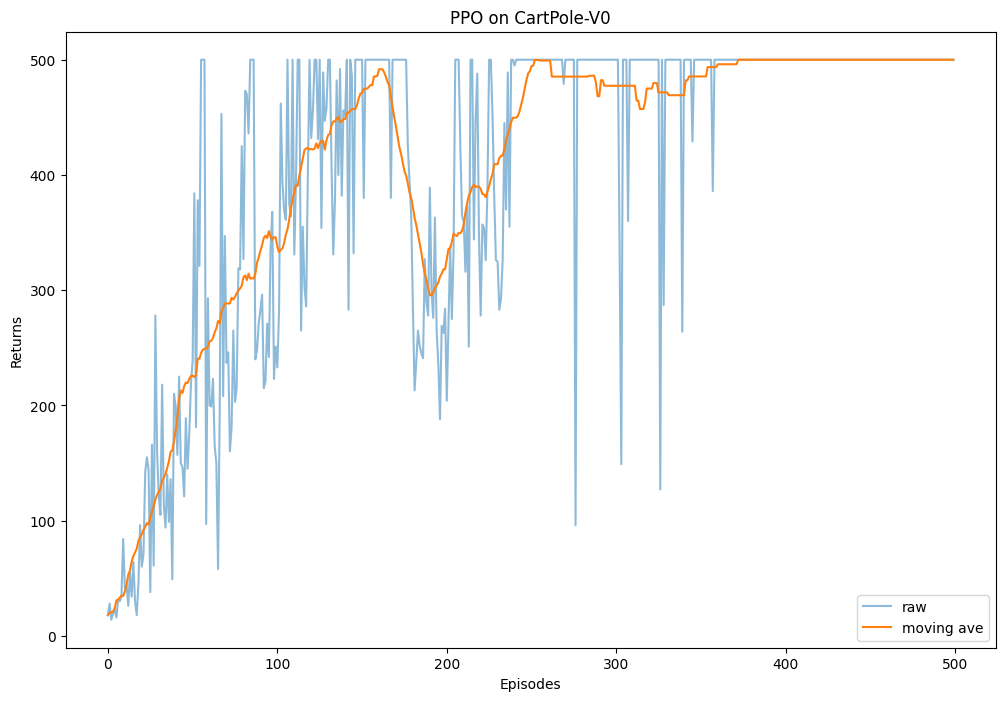

In [3]:
    # show policy performence
mv_return_list = moving_average(return_list, 29)
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(12,8))
plt.plot(episodes_list, return_list, label='raw', alpha=0.5)
plt.plot(episodes_list, mv_return_list, label='moving ave')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'{agent._get_name()} on CartPole-V0')
plt.legend()
plt.show()                           
